In [ ]:
!pip install -q timm medmnist torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.1 MB/s eta 0:00:00


In [ ]:
import torch, torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl

device = xm.xla_device()
xm.master_print("Using device:", device)


/tmp/ipython-input-30381429.py:5: DeprecationWarning: Use torch_xla.device instead
  device = xm.xla_device()


Using device: xla:0


In [ ]:
import timm
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchmetrics.classification import Accuracy
from sklearn.metrics import confusion_matrix, classification_report

from medmnist import PneumoniaMNIST
import torchvision.transforms as T


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 1e-4
NUM_CLASSES = 2


In [ ]:
train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

train_ds = PneumoniaMNIST(split="train", transform=train_tfms, download=True)
val_ds   = PneumoniaMNIST(split="val", transform=val_tfms, download=True)
test_ds  = PneumoniaMNIST(split="test", transform=val_tfms, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 4.17M/4.17M [00:06<00:00, 599kB/s]


In [ ]:
def train_epoch_tpu(model, loader, optimizer, criterion, acc):
    model.train()
    total_loss = 0.0
    acc.reset()

    para_loader = pl.ParallelLoader(loader, [device]).per_device_loader(device)

    for x, y in para_loader:
        x = x.to(device)
        y = y.squeeze().to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)

        loss.backward()
        xm.optimizer_step(optimizer)

        total_loss += loss.item()
        acc.update(logits.argmax(1), y)

    return total_loss / len(loader), acc.compute().item()


@torch.no_grad()
def validate_epoch_tpu(model, loader, criterion, acc):
    model.eval()
    total_loss = 0.0
    acc.reset()

    para_loader = pl.ParallelLoader(loader, [device]).per_device_loader(device)

    for x, y in para_loader:
        x = x.to(device)
        y = y.squeeze().to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item()
        acc.update(logits.argmax(1), y)

    return total_loss / len(loader), acc.compute().item()


In [ ]:
def run_vanilla_vit(epochs):
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=NUM_CLASSES
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    acc = Accuracy(task="binary").to(device)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for ep in range(epochs):
        tr_loss, tr_acc = train_epoch_tpu(
            model, train_loader, optimizer, criterion, acc
        )
        val_loss, val_acc = validate_epoch_tpu(
            model, val_loader, criterion, acc
        )

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(val_acc)

        xm.master_print(
            f"[{ep+1}/{epochs}] "
            f"Train Acc: {tr_acc:.4f} | Val Acc: {val_acc:.4f}"
        )

    return model, history


In [ ]:
vit_30_model, vit_30_hist = run_vanilla_vit(30)
vit_40_model, vit_40_hist = run_vanilla_vit(40)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


[1/30] Train Acc: 0.8795 | Val Acc: 0.9256
[2/30] Train Acc: 0.9437 | Val Acc: 0.9714
[3/30] Train Acc: 0.9477 | Val Acc: 0.9561
[4/30] Train Acc: 0.9505 | Val Acc: 0.9656
[5/30] Train Acc: 0.9560 | Val Acc: 0.9542
[6/30] Train Acc: 0.9634 | Val Acc: 0.9618
[7/30] Train Acc: 0.9639 | Val Acc: 0.9351
[8/30] Train Acc: 0.9632 | Val Acc: 0.9790
[9/30] Train Acc: 0.9681 | Val Acc: 0.9752
[10/30] Train Acc: 0.9724 | Val Acc: 0.9714
[11/30] Train Acc: 0.9690 | Val Acc: 0.9752
[12/30] Train Acc: 0.9741 | Val Acc: 0.9733
[13/30] Train Acc: 0.9724 | Val Acc: 0.9714
[14/30] Train Acc: 0.9722 | Val Acc: 0.9733
[15/30] Train Acc: 0.9753 | Val Acc: 0.9752
[16/30] Train Acc: 0.9743 | Val Acc: 0.9580
[17/30] Train Acc: 0.9756 | Val Acc: 0.9695
[18/30] Train Acc: 0.9760 | Val Acc: 0.9752
[19/30] Train Acc: 0.9762 | Val Acc: 0.9656
[20/30] Train Acc: 0.9824 | Val Acc: 0.9618
[21/30] Train Acc: 0.9783 | Val Acc: 0.9580
[22/30] Train Acc: 0.9779 | Val Acc: 0.9542
[23/30] Train Acc: 0.9762 | Val Acc: 0.96

In [ ]:
torch.save(vit_30_model.state_dict(), "vanilla_vit_30.pth")
torch.save(vit_40_model.state_dict(), "vanilla_vit_40.pth")

with open("vanilla_vit_30_hist.pkl", "wb") as f:
    pickle.dump(vit_30_hist, f)

with open("vanilla_vit_40_hist.pkl", "wb") as f:
    pickle.dump(vit_40_hist, f)


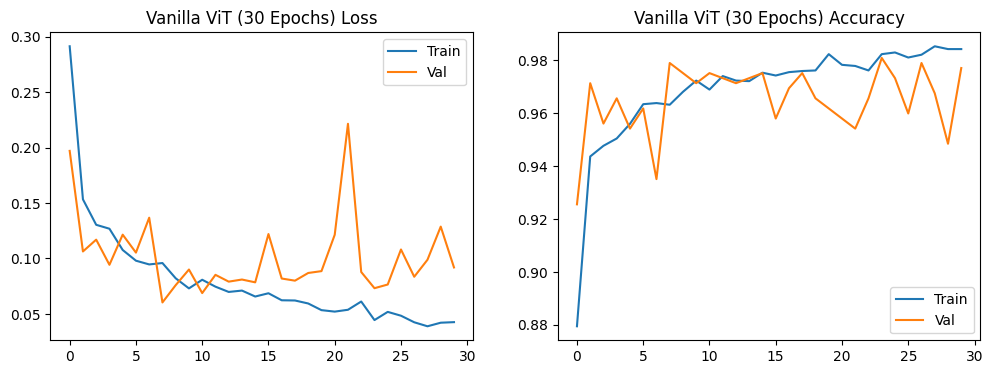

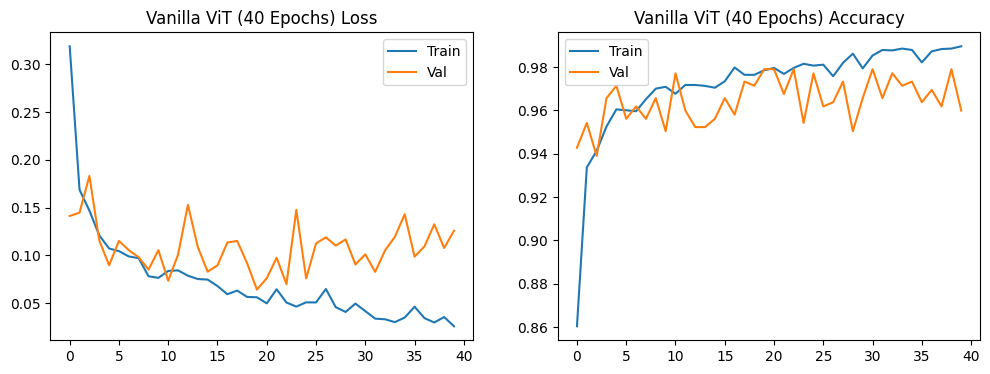

In [ ]:
def plot_curves(hist, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(hist["train_loss"], label="Train")
    plt.plot(hist["val_loss"], label="Val")
    plt.title(f"{title} Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist["train_acc"], label="Train")
    plt.plot(hist["val_acc"], label="Val")
    plt.title(f"{title} Accuracy")
    plt.legend()

    plt.show()

plot_curves(vit_30_hist, "Vanilla ViT (30 Epochs)")
plot_curves(vit_40_hist, "Vanilla ViT (40 Epochs)")


In [ ]:
@torch.no_grad()
def test_evaluate(model, loader, title):
    model.eval()
    y_true, y_pred = [], []

    para_loader = pl.ParallelLoader(loader, [device]).per_device_loader(device)

    for x, y in para_loader:
        x = x.to(device)

        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()

        y_true.extend(y.squeeze().cpu().numpy())
        y_pred.extend(preds)

    print(title)
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(
        y_true, y_pred,
        target_names=["Normal", "Pneumonia"]
    ))

# Run test
test_evaluate(vit_40_model, test_loader, "Vanilla ViT (40 Epochs)")


Vanilla ViT (40 Epochs)
[[114 120]
 [  3 387]]
              precision    recall  f1-score   support

      Normal       0.97      0.49      0.65       234
   Pneumonia       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.74      0.76       624
weighted avg       0.84      0.80      0.78       624

